In [4]:
import h5py
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

from scipy import stats

from nilearn import datasets, plotting
# Note nilearn plotting incompatible with Mtplotlib version >= 3.1

from pathlib import Path
import os
import re
import pandas as pd

from tqdm import tqdm

In [5]:
h5_key = 'latent'
## Define paths
basedir = Path('..')
datadir = basedir / 'data'
rawdir = datadir / 'raw'
gccadir = datadir / 'interim' / 'gcca_raw-True_ZG-3_reduced'
externaldir = datadir / 'external'
figuredir = basedir / 'reports' / 'gcca_raw-True_ZG-3_reduced'

## Load Files

In [6]:
def get_files(path,
              level='(e|n)',
              subject='([0-9]{3})',
              task='(.+?)',
              filetype='h5',
              flag=''):
    files = []
    query = f'^{level}_sub-'
    query += f'{subject}_ses-1_'
    query += f'task-{task}{flag}\.{filetype}'
    for f in os.listdir(path):
        match = re.search(query, f)
        if match:
            files.append((f, match.groups()))
    
    return(files)

In [7]:
len(get_files(path=gccadir))

228

In [8]:
# plot on fsa5 surface:
fsa5 = datasets.fetch_surf_fsaverage()

In [47]:
def visualize_embeddings(embeddings, level, task, statistic, save=True, vmax=None, symmetric_cbar=True,colorbar=False, n_embed = 3):
    plt.clf()
    res_scale = 2
    fig, axes = plt.subplots(n_embed, 4, subplot_kw={'projection': '3d'}, figsize=(res_scale*n_embed*1.5, res_scale*n_embed))
    if n_embed==1:
        axes = [axes]
    
    plt.subplots_adjust(wspace=0, hspace=0)


    for i,ax in enumerate(axes):
        X = embeddings[:, i]

        cortex_left = nib.freesurfer.read_label(externaldir / 'lh.cortex.label')

        conn_map = np.zeros(10242)
        conn_map[cortex_left] = X[:len(cortex_left)]

        plotting.plot_surf_stat_map(fsa5.infl_left, 
          conn_map, hemi='left', colorbar=False, cmap='RdBu', axes = ax[0],
          vmax=vmax, symmetric_cbar=symmetric_cbar)

        plotting.plot_surf_stat_map(fsa5.infl_left,
          conn_map, hemi='left', colorbar=False, cmap='RdBu', view='medial', axes=ax[1], 
            vmax=vmax,symmetric_cbar=symmetric_cbar)

        cortex_right = nib.freesurfer.read_label(externaldir / 'rh.cortex.label')

        conn_map = np.zeros(10242)
        conn_map[cortex_right] = X[len(cortex_left):]

        plotting.plot_surf_stat_map(fsa5.infl_right, 
          conn_map, hemi='right', colorbar=False, cmap='RdBu', axes = ax[2], 
           vmax=vmax,symmetric_cbar=symmetric_cbar)

        plotting.plot_surf_stat_map(fsa5.infl_right,
          conn_map, hemi='right', colorbar=colorbar, cmap='RdBu', view='medial', axes=ax[3], 
            vmax=vmax,symmetric_cbar=symmetric_cbar)

    #fig.suptitle(f'{statistic}: {level}, {task}', fontsize=20)
    if save:
        plt.savefig(figuredir / f'{level}-{task}-{statistic}.png', format='png', bbox_inches='tight')
    else:
        plt.show()
    plt.close(fig)

In [10]:
tasks = ['restingstate', 'openmonitoring', 'compassion']
levels = ['e', 'n']

In [12]:
## Get filenames for each task, novice vs. experienced


## Load a single set of latents
#for task,level in np.array(np.meshgrid(tasks,levels)).T.reshape(-1,2):

#stds = {l:{} for l in levels}
avgs = {l:{} for l in levels}

#latents = {t:{l:[] for l in tasks} for t in levels}

c_offset = 0
n_components = 3

vmax_avg = 0
vmax_std = 0

for level in levels:#level=levels[1]
    for task in tasks:
        paths = get_files(path=gccadir, level=level, task=task, flag='_gcca-zg')
        subjs = []
        latents = []
        
        n_load = len(paths)

        for path,subj in tqdm(paths[:n_load]):
            h5f = h5py.File(gccadir / path,'r')
            latent = h5f[h5_key][:][:,c_offset:n_components + c_offset]
            h5f.close()
            latents.append(latent)
            subjs.append(subj)

        avgs[level][task] = np.mean(np.array(latents), axis=0)
        #stds[level][task] = np.std(np.array(latents), axis=0)
        
        if max(avgs[level][task][:,:n_components].flatten()) > vmax_avg:
            vmax_avg = max(avgs[level][task][:,:n_components].flatten())
        #if max(stds[level][task][:,:n_components].flatten()) > vmax_std:
        #    vmax_std = max(stds[level][task][:,:n_components].flatten())

#vmax = max([max(l[:,:4].flatten()) for l in latents.])

100%|██████████| 47/47 [00:00<00:00, 98.13it/s]


In [21]:
def make_cbar(vmax, label, vmin=None):
    if vmin is None:
        vmin = -vmax
        cmap = mpl.cm.RdBu
    else:
        cmap = mpl.cm.Blues
    fig, ax = plt.subplots(figsize=(1, 15))
    fig.subplots_adjust(bottom=0.5)

    #cmap = mpl.cm.RdBu
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

    cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                    norm=norm,
                                    orientation='vertical')
    cb1.ax.tick_params(labelsize=20) 
    
    #cb1.set_clim(vmin, vmax)
    #cb1.set_label('Some Units')
    plt.savefig(figuredir / f'{label}_colorbar.png', format='png', bbox_inches='tight')
    #plt.plot()
    plt.close(fig)

In [12]:
colorbar=False
mpl.use('Agg')

if not colorbar:
    make_cbar(vmax_avg, 'avg')
    #make_cbar(vmax_std, 'std', vmin=0)

for level in levels:
    for task in tasks:
        print(level, task)
        visualize_embeddings(avgs[level][task], level=level, task=task, vmax=vmax_avg, statistic='avg', save=True,colorbar=colorbar, n_embed=n_components)
        #visualize_embeddings(stds[level][task], level=level, task=task, vmax=vmax_std, statistic='std', save=True,colorbar=colorbar, n_embed=n_components)

e restingstate
e openmonitoring
e compassion
n restingstate
n openmonitoring
n compassion


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

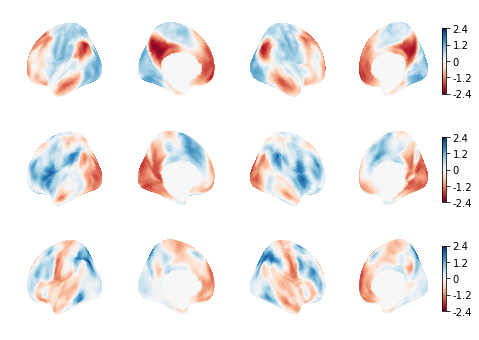

In [11]:
visualize_embeddings(avgs[levels[0]][tasks[0]], level=levels[0], task=tasks[0], vmax=vmax_avg, statistic='avg', save=False,colorbar=True, n_embed=n_components)

In [22]:
make_cbar(vmax_avg, 'avg')

## Group Effect

In [50]:
def plot_group_effects(level_1, level_2, task_1, task_2, flag, label, vmax=vmax_avg, scaled=False):
    paths_1 = get_files(path=gccadir, level=level_1, task=task_1, flag=flag)
    paths_2 = get_files(path=gccadir, level=level_2, task=task_2, flag=flag)

    n_components = 3
    latents_GE_ALL = None

    latents_1 = []
    latents_2 = []

    for path,subj in tqdm(paths_1):
        h5f = h5py.File(gccadir / path,'r')
        latent = h5f[h5_key][:][:,:n_components]
        h5f.close()
        latents_1.append(latent)

    for path,subj in tqdm(paths_2):
        h5f = h5py.File(gccadir / path,'r')
        latent = h5f[h5_key][:][:,:n_components]
        h5f.close()
        latents_2.append(latent)

    n1 = len(paths_1)
    n2 = len(paths_2)

    ## Difference of means
    latents_GE_ALL = np.mean(np.array(latents_1), axis=0) - np.mean(np.array(latents_2), axis=0)

    visualize_embeddings(latents_GE_ALL, level=f'{label}', task='', vmax=vmax, statistic='avg', save=True, colorbar=False, n_embed=n_components)

    ## Normalize by the weighted average sample standard deviation
    latents_GE_ALL = np.divide(latents_GE_ALL, 
                               np.sqrt(np.var(np.array(latents_1), axis=0, ddof = 1) / n1 + 
                                       np.var(np.array(latents_2), axis=0, ddof = 1) / n2)) 

    if scaled:
        vmax_GE_ALL = max(latents_GE_ALL.flatten())
        
        make_cbar(vmax_GE_ALL, f'avg_{label}_Scaled')
        visualize_embeddings(latents_GE_ALL, level=f'{label}', task='Scaled', vmax=vmax, statistic='avg', save=True, colorbar=False, n_embed=n_components)
    
    print(f'Finished {label}')
    
    return(latents_GE_ALL)

### Pairwise

In [48]:
level_1 = 'e'
level_2= 'n'
tasks = ['openmonitoring', 'compassion', 'restingstate']
flag = '_gcca-zg'

latents = []

for task in tasks:
    latents.append(plot_group_effects(level_1, level_2, task, task, flag, task, vmax_avg))

  0%|          | 0/47 [00:00<?, ?it/s]

Finished openmonitoring


  0%|          | 0/47 [00:00<?, ?it/s]

Finished compassion


100%|██████████| 47/47 [00:00<00:00, 263.76it/s]


Finished restingstate


<Figure size 432x288 with 0 Axes>

In [53]:
vmax_group_effect = np.max(np.array(latents).flatten())

make_cbar(vmax_group_effect, f'avg_Pairs_Scaled')

for task,latent in zip(tasks, latents):
    visualize_embeddings(latent, level=f'{task}', task='Scaled', vmax=vmax_group_effect, statistic='avg', save=True, colorbar=False, n_embed=n_components)
    print(f'Finished {task}')

<Figure size 432x288 with 0 Axes>

### Expert All vs. Novice All

In [51]:
level_1 = 'e'
level_2= 'n'
task_1 = '(openmonitoring|compassion|restingstate)'
task_2 = '(openmonitoring|compassion|restingstate)'
flag = '_gcca-zg'
label='GE_All'

plot_group_effects(level_1, level_2, task_1, task_2, flag, label, scaled=True);

100%|██████████| 141/141 [00:00<00:00, 585.81it/s]


Finished GE_All


array([[-0.49019931, -0.04626194, -1.01337353],
       [-0.30787582, -0.67348367, -1.29323429],
       [ 0.18605133, -0.43603086, -1.31274062],
       ...,
       [-1.8001167 , -0.13501723,  1.63041895],
       [-2.47385405, -0.6687676 ,  1.67568504],
       [-2.72484321, -1.0492241 ,  1.72446052]])

<Figure size 432x288 with 0 Axes>

### Expert Meditating vs. Novice Resting

In [52]:
level_1 = 'e'
level_2= 'n'
task_1 = '(openmonitoring|compassion)'
task_2 = 'restingstate'
flag = '_gcca-zg'
label='GE_MvsR'

plot_group_effects(level_1, level_2, task_1, task_2, flag, label, scaled=True);

100%|██████████| 47/47 [00:00<00:00, 611.95it/s]


Finished GE_MvsR


array([[ 0.59354299,  0.27895274, -1.56409088],
       [-0.24987697, -0.53543196, -1.23009529],
       [ 0.26007364, -0.21479244, -0.13590912],
       ...,
       [ 0.35730123, -1.49418439,  0.9651187 ],
       [-0.02353138, -2.16222211,  1.13469605],
       [-0.38403898, -2.43305195,  0.92290569]])

<Figure size 432x288 with 0 Axes>

## Similar Variances?
Do the experts and novices have similar variances

In [54]:
level_1 = 'e'
level_2= 'n'
task_1 = '(openmonitoring|compassion|restingstate)'
task_2 = '(openmonitoring|compassion|restingstate)'
flag = '_gcca-zg'
n_components = 3

paths_1 = get_files(path=gccadir, level=level_1, task=task_1, flag=flag)
paths_2 = get_files(path=gccadir, level=level_2, task=task_2, flag=flag)

latents_1 = []
latents_2 = []

for path,subj in tqdm(paths_1):
    h5f = h5py.File(gccadir / path,'r')
    latent = h5f[h5_key][:][:,:n_components]
    h5f.close()
    latents_1.append(latent)

for path,subj in tqdm(paths_2):
    h5f = h5py.File(gccadir / path,'r')
    latent = h5f[h5_key][:][:,:n_components]
    h5f.close()
    latents_2.append(latent)
    
vars_1 = np.var(np.array(latents_1), axis=0, ddof = 1)
vars_2 = np.var(np.array(latents_2), axis=0, ddof = 1)

100%|██████████| 141/141 [00:05<00:00, 26.04it/s]


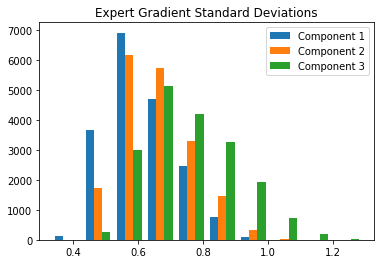

In [57]:
plt.hist(np.sqrt(vars_1))
plt.title('Expert Gradient Standard Deviations')
plt.legend(['Component 1', 'Component 2', 'Component 3'])
plt.show()

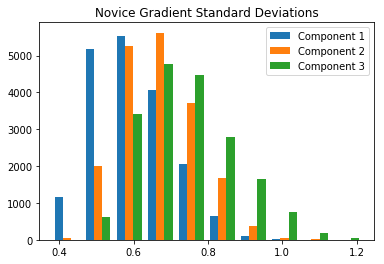

In [58]:
plt.hist(np.sqrt(vars_2))
plt.title('Novice Gradient Standard Deviations')
plt.legend(['Component 1', 'Component 2', 'Component 3'])
plt.show()

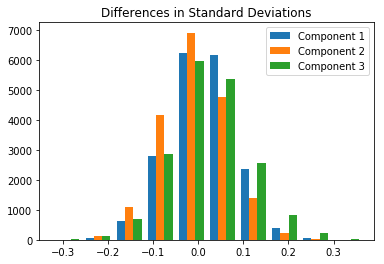

In [59]:
plt.hist(np.sqrt(vars_1)- np.sqrt(vars_2))
plt.title('Differences in Standard Deviations')
plt.legend(['Component 1', 'Component 2', 'Component 3'])
plt.show()

In [61]:
np.mean(np.sqrt(vars_1)- np.sqrt(vars_2))

0.007799656711528378